# Loading Deepmind's Diplomacy trajectory

In [ ]:
import numpy as np

In [ ]:
action_outputs = np.load(file='../data/actions_outputs.npz', allow_pickle=True)

In [ ]:
action_outputs[1][0]

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame.from_dict(action_outputs[0][0]).corr(method='pearson')

In [ ]:
legal_actions = np.load(file='../data/legal_actions.npz', allow_pickle=True)

In [ ]:
len(legal_actions)

In [ ]:
legal_actions[0].shape

In [ ]:
observations = np.load(file='../data/observations.npz', allow_pickle=True)

In [ ]:
len(observations)

In [ ]:
observations[1]

In [ ]:
step_outputs = np.load(file='../data/step_outputs.npz', allow_pickle=True)

In [ ]:
len(step_outputs)

In [ ]:
step_outputs[0]

# Loading human plays' data

In [ ]:
import json
import pandas as pd
import mmap

In [ ]:
# Load the json data
games_jsons = []
with open("../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl", "r+b") as json_file:
    with mmap.mmap(json_file.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_object:
        for i, line in enumerate(iter(mmap_object.readline, b"")):
            games_jsons.append(json.loads(line.decode("utf-8")))
            if i == 2:
                break

In [ ]:
# Convert to a pandas dataframe
df = pd.DataFrame(games_jsons)

In [ ]:
df = df[df["map"] == "standard"].reset_index(drop=True)

In [ ]:
df

In [ ]:
games = df['phases']

In [ ]:
games.apply(lambda x: x[0])

In [ ]:
type(games)

In [ ]:
for game in games:
    for ix, iy in enumerate(game):
        game[ix]['phase_id'] = ix

In [ ]:
def flatten_json(nested_json):
    out = {}
    x = nested_json
    
    out['game_id'] = x['state']['game_id']
    out['phase_id'] = x['phase_id']
    out['phase_name'] = x['name']
    results_units = [x for x in x['results']]
    # print("results are: ", results_units)
    assert x['orders'].items() 
    for key, value in x['orders'].items():
        if value is None:
            # out['coordinator'] = key
            # out['type'] = 'N'
            # out['current_location'] = 'N'
            # out['action'] = 'N'
            # out['results'] = 'N'
            # out['via'] = 'N'
            # out['impact_location'] = 'N'
            # yield(out)
            pass
        else:
            if value:
                for ix in value:
                    out['coordinator'] = key
                    out['type'] = ix.split()[0]
                    out['current_location'] = ix.split()[1]
                    out['action'] = ix.split()[2]
                    unit = ix.split()[0]+ ' ' + ix.split()[1]
                    # print("unit result is: ", unit , unit in results_units, results_units)
                    if x['results']:
                        out['results'] = x['results'][unit]
                    else:
                        print("empty results")
                        print(ix)
                    if unit in results_units:
                        results_units.remove(unit)
                    # out['via'] = 'N'
                    out['impact_location'] = []
                    if out['action'] == '-' or out['action'] == 'R':
                        assert len(ix.split()) == 4 or len(ix.split()) == 5, ix
                        out['impact_location'] = ix.split()[3]
                        # if ix.split()[-1] == 'VIA':
                        #     out['via'] = ix.split()[-1]
                    yield(out)

    if len(results_units)>0:
        # print("adding new rows: ", results_units)
        for ix in results_units:
            out['coordinator'] = 'N'
            for key in x["state"]["units"]:
                if ix in x["state"]["units"][key]:
                    # print(key, value, "found")
                    out['coordinator'] = key
            out['type'] = ix.split()[0] if len(ix.split()) > 1 else 'N'
            out['current_location'] = ix.split()[1] if len(ix.split()) > 1 else ix
            out['action'] = 'N'
            out['results'] = x['results'][ix]
            # out['via'] = 'N'
            out['impact_location'] = 'N'
            yield(out)

In [ ]:
complete_df = pd.DataFrame()
for idx, game in enumerate(games):
  # print("game ", idx)
  for idx, phase in enumerate(game):
    # print("phase ", idx)
    row_i = flatten_json(phase)
    if row_i != None:
      for ix in row_i:  
        row_df = pd.DataFrame(ix.items()).T
        complete_df = pd.concat((complete_df,row_df), axis=0, ignore_index=True)

new_header = complete_df.iloc[0] #grab the first row for the header
complete_df = complete_df[1:] #take the data less the header row
complete_df.columns = new_header #set the header row as the df header
complete_df = complete_df.loc[::2]
complete_df = complete_df.reset_index(drop=True)

In [ ]:
complete_df

In [ ]:
complete_df['unique_unit_id'] = -1

In [ ]:
complete_df

# Temporal Binding

In [ ]:
def assign_unit_id(phase_df, source_unit_id_map, dest_unit_id_map, _id):

    # fror each row in the phase df
    for idx, row in phase_df.iterrows():

        # if current location or type of army in invalid skip the row (we only deal with valid orders)
        if row['current_location'] == 'N' or row['type'] == 'N':
            continue
        
        # get the current location of the unit
        source_unit = row['type'] + ' ' + row['current_location']

        # if the location is not in the map, add it to the map (in other phases the same unit can be used, hence checking the condition _ dictionaries are global, have data across phases)
        if source_unit not in source_unit_id_map:
            source_unit_id_map[source_unit] = _id
            _id += 1

        # destination dict is synced with source dict after the loop, so that we can use updated info at the beginning of each assignment
        # row['unique_unit_id'] = source_unit_id_map[source_unit]
        phase_df.loc[idx,'unique_unit_id'] = source_unit_id_map[source_unit]


        # print(idx, row)

        if row['action'] == '-':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_location = row['impact_location']
                    try:
                        dest_unit = row['type'] + ' ' + dest_location
                    except:
                        print("dest location error", row)
                        return
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map[source_unit]
                        source_unit_id_map.pop(source_unit)
                elif 'disband' in result:
                    source_unit_id_map.pop(source_unit)
                    
        elif row['action'] == 'R':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_location = row['impact_location']
                    dest_unit = row['type'] + ' ' + dest_location
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map[source_unit]
                        source_unit_id_map.pop(source_unit)
                elif 'disband' in result:
                    source_unit_id_map.pop(source_unit)

        elif row['action'] == 'D':
            source_unit_id_map.pop(source_unit)
        
        elif row['action'] == 'B':
            assert source_unit in source_unit_id_map

        # phase_df.loc[idx] = row

    # merge the source and destination dictionaries into one
    source_unit_id_map.update(dest_unit_id_map)
    # remove the destination dict (values get updated based on old data if we don't do this)
    dest_unit_id_map = {}

    return phase_df, source_unit_id_map, dest_unit_id_map, _id


In [ ]:
unique_games = complete_df["game_id"].unique()

In [ ]:
unique_games

In [ ]:
complete_df[complete_df["game_id"] == 'uXFQ2zgI-DUrgwlS']['phase_id'].unique()

In [ ]:
game_phase_df_list = []
for idx, game_id in enumerate(unique_games):
    print(idx, game_id)
    s_dict = {}
    d_dict = {}
    _id = 1
    unique_phases = complete_df[complete_df["game_id"] == game_id]['phase_id'].unique()
    for phase in unique_phases:
        # print("phase number is", phase)
        phase_df = complete_df[complete_df["phase_id"] == phase]
        res_df, s_dict, d_dict, _id = assign_unit_id(phase_df, s_dict, d_dict, _id)
        game_phase_df_list.append(phase_df)

In [ ]:
cdf = pd.concat(game_phase_df_list)

In [ ]:
cdf.head(40)

<AxesSubplot:xlabel='phase_id'>

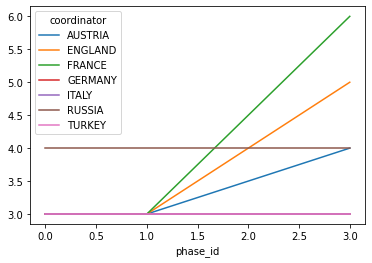

In [61]:
spring_fall_phases=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R')
cdf[spring_fall_phases].groupby(["coordinator","phase_id"])["unique_unit_id"].nunique().unstack().T.plot()

In [ ]:
print(cdf[cdf["game_id"] == "uXFQ2zgI-DUrgwlS"].sort_values(by=['phase_id', 'coordinator']).to_string())

In [ ]:
with open('out_df.txt', 'w') as f:
    print(cdf.groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().to_string(), file=f)

In [ ]:
games

In [ ]:
complete_df[complete_df["game_id"] == 'Fdp3XM14WLTn5vBF']

In [ ]:
games_jsons